# Sentiment Analysis

# Dataset Download & Extraction

In [1]:
!curl -L -o sentiment-analysis-dataset.zip https://www.kaggle.com/api/v1/datasets/download/abhi8923shriv/sentiment-analysis-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 54.4M  100 54.4M    0     0  54.5M      0 --:--:-- --:--:-- --:--:--  188M


In [2]:
!unzip -q sentiment-analysis-dataset.zip

## Data Preprocessing

In [3]:
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, logging
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.utils.class_weight import compute_class_weight

# optimizer from hugging face transformers
from torch.optim import AdamW

# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
train_df = pd.read_csv("train.csv", encoding='latin1')
test_df = pd.read_csv("test.csv", encoding='latin1')

## Unique Sentiments

In [6]:
test_df = test_df.dropna(subset=['sentiment'])
test_df['sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

## Tokenization & Input Formatting

In [7]:
# Create a mapping for sentiment labels
sentiment_mapping = {
    'positive': 0,
    'negative': 1,
    'neutral': 2
}

# Apply the mapping to create the 'label' column in train_df
train_df['label'] = train_df['sentiment'].map(sentiment_mapping)

# Apply the mapping to create the 'label' column in test_df
test_df['label'] = test_df['sentiment'].map(sentiment_mapping)

In [8]:
train_text, val_text, train_labels, val_labels = train_test_split(train_df['text'], train_df['label'],
                                                                    random_state=1000,
                                                                    test_size=0.3,
                                                                    stratify=train_df['label'])


test_text, test_labels = test_df['text'], test_df['label']

In [10]:
# Suppress Hugging Face and Transformers logs, warnings, and download bars
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Sample data
text = [
    "I absolutely loved the movie! The acting was fantastic and the story was touching.",
    "What a terrible product. It broke after just two days. Total waste of money."
]

# Encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# Output
print(sent_id)

{'input_ids': [[101, 1045, 7078, 3866, 1996, 3185, 999, 1996, 3772, 2001, 10392, 1998, 1996, 2466, 2001, 7244, 1012, 102, 0], [101, 2054, 1037, 6659, 4031, 1012, 2009, 3631, 2044, 2074, 2048, 2420, 1012, 2561, 5949, 1997, 2769, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

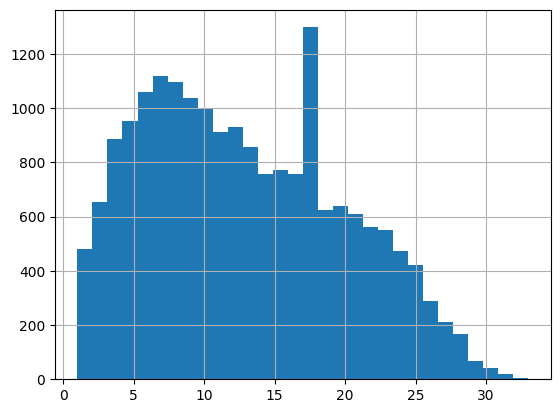

In [11]:
seq_len = [len((str)(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [12]:
MAX_SEQ_LEN = 40
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    [str(text) for text in train_text],
    max_length = MAX_SEQ_LEN,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    [str(text) for text in val_text],
    max_length = MAX_SEQ_LEN,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    [str(text) for text in test_text],
    max_length = MAX_SEQ_LEN,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Freezing BERT Parameters

In [13]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Model Architecture

In [14]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Model Initialization

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Training Setup

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model
      out = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(out.pooler_output)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      x = self.softmax(x)

      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [18]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-4)

## Model Training

In [19]:
#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.06742134 1.17716174 0.82395271]


## Model Evaluation

In [20]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights)

epochs = 20

In [21]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

## Loading Best Model

In [22]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Predictions on Test Data

In [23]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training Loss: 1.026
Validation Loss: 0.939

 Epoch 2 / 20
  Batch    50  of    602.
  Batch   100  of    602.
  Batch   150  of    602.
  Batch   200  of    602.
  Batch   250  of    602.
  Batch   300  of    602.
  Batch   350  of    602.
  Batch   400  of    602.
  Batch   450  of    602.
  Batch   500  of    602.
  Batch   550  of    602.
  Batch   600  of    602.

Evaluating...
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Training L

In [24]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [25]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [26]:
preds = np.argmax(preds, axis = 1)

In [27]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1103
           1       0.54      0.80      0.64      1001
           2       0.65      0.45      0.53      1430

    accuracy                           0.61      3534
   macro avg       0.62      0.64      0.62      3534
weighted avg       0.63      0.61      0.61      3534

